In [45]:
import os

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, chi2, SelectPercentile, SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

# %matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib as mpl

# import seaborn as sns

In [26]:
# set some constants
RANDOM_STATE=42
TESTSIZE = 0.2
VALSIZE = 0.2
# number of features to select
NUMFEATURES = 5
# or a top percentile of features by importance to select
PERCFEATURES = 20
# name of the target columns
TARGET = 'CONDITION'

In [27]:
def load_datasets():
    datasets = []
    dataset_names = []
    for filename in os.listdir('data'):
        path = os.path.join('data', filename)
        dname = filename.split('.')[0]
        if dname == 'PHQ9_GAD7_df':
            sep=';'
        else:
            sep=','
        datasets.append(pd.read_csv(path, sep=sep))
        dataset_names.append(dname)
        print(f"Loaded {filename} as {dname}")
    return datasets, dataset_names

In [28]:
datasets, dataset_names = load_datasets()

Loaded IADQ_df.csv as IADQ_df
Loaded PHQ9_GAD7_df.csv as PHQ9_GAD7_df
Loaded PRMQ_df.csv as PRMQ_df
Loaded RAW_DDDT.CSV as RAW_DDDT


In [29]:
# probably not used anymore but i spent too much time on this to delete it 
# also looks cool so idc

from itertools import combinations

def gen_interaction_combinations(
    col_names: list[str],
    max_order,
) -> list[tuple[str]]:
    """
    Generate all possible combinations of orders [1,...,max_order].\n
    Used to add interactions to the data.
    """
    res = []
    for order in range(1,max_order):
        res.append(list(combinations(col_names, order + 1)))
    return res

def calc_interaction(
    data: pd.DataFrame, 
    cols: list
) -> pd.Series:
    """ 
    Multiply specified columns of a dataframe.\n
    Returns a new series.
    """
    res = pd.Series(data=np.ones(data.shape[0]))
    for c in cols:
        res *= data[c]
    return res

def add_interactions(
    df: pd.DataFrame,
    col_names: list[str],
    max_order: int = 0
) -> pd.DataFrame:
    """
    Add all possible interactions between specified columns up to some order.\n
    """
    res = df.copy()

    assert max_order >= 0
    if max_order == 0:
        max_order = len(col_names)
        
    if max_order == 1:
        return res

    all_ints = gen_interaction_combinations(col_names=col_names, max_order=max_order)
    for ints_ord_i in all_ints:
        for inter in ints_ord_i:
            new_col = calc_interaction(df,inter)
            res['.'.join(map(str,inter))] = new_col
    return res

Preprocessing

In [30]:
def separate_target(data:np.ndarray, target_ind:int):
    return data[:,:target_ind], data[:,target_ind]

def check_split_integrity(
    data: pd.DataFrame,
    x_train: np.ndarray,
    x_val: np.ndarray, 
    x_test: np.ndarray,
    train_size: float = 1-VALSIZE-TESTSIZE, 
    val_size: float = VALSIZE, 
    test_size: float = TESTSIZE
    ):
    assert x_train.shape[1] == data.shape[1] - 1
    assert x_val.shape[1] == data.shape[1] - 1
    assert x_test.shape[1] == data.shape[1] - 1

    assert x_train.shape[0] + x_val.shape[0] + x_test.shape[0] == data.shape[0]
    assert abs(x_train.shape[0] - int(train_size*data.shape[0])) <= 1
    assert abs(x_val.shape[0] - int(val_size*data.shape[0])) <= 1
    assert abs(x_test.shape[0] - int(test_size*data.shape[0])) <= 1

    return


In [31]:
def preprocess(
    data: pd.DataFrame, 
    target_column: str,
    val_size: float=VALSIZE, 
    test_size: float=TESTSIZE, 
    random_state: float=RANDOM_STATE,
    scale: bool=False,
    center: bool=False
):
    """
    Function that combines all preprocessing steps.\n
    Returns the training, validation and test sets as numpy arrays.\n
    In our case, preserves column structure (doesn't necessarily in the general case though).\n
    """
    data_trainval, data_test = train_test_split(data, test_size=test_size,random_state=random_state, stratify=data[target_column])
    data_train, data_val = train_test_split(data_trainval, test_size=val_size/(1-test_size),random_state=random_state, stratify=data_trainval[target_column])
    predictors_pipeline = Pipeline(steps=[
        ('scale_numerics', StandardScaler(with_mean=center, with_std=scale))
    ])
    target_pipeline = Pipeline(steps=[
        ('encode_target', sklearn.preprocessing.OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('predictors', predictors_pipeline, data.columns[data.columns != target_column]),
        ('target', target_pipeline, [target_column])
    ], remainder='passthrough')

    data_train_pr = preprocessor.fit_transform(data_train)
    data_val_pr = preprocessor.transform(data_val)
    data_test_pr = preprocessor.transform(data_test)

    # x_train = data_train_pr[:,:target_column_ind]
    # y_train = data_train_pr[target_column_ind]
    # x_val = data_val_pr[:,:target_column_ind]
    # y_val = data_val_pr[target_column_ind]
    # x_test = data_test_pr[:,:target_column_ind]
    # y_test = data_test_pr[target_column_ind]
    # feature_names = preprocessor.get_feature_names_out()
    # data_train_pr = pd.DataFrame(data_train_pr, columns=feature_names)
    # data_val_pr = pd.DataFrame(data_val_pr, columns=feature_names)
    # data_test_pr = pd.DataFrame(data_test_pr, columns=feature_names)

    return data_train_pr, data_val_pr, data_test_pr
# X_train, y_train = separate_target(data_train_pr, target_col)
# X_val, y_val = separate_target(data_val_pr, target_col)
# X_test, y_test = separate_target(data_test_pr, target_col)


In [32]:
def plot_feature_importances(X, y, feature_names_in, score_func=chi2):
    selector = SelectPercentile(score_func=score_func, percentile=PERCFEATURES)
    selector.fit(X, y)
    ax = plt.figure().add_subplot()
    ax.bar(feature_names_in, selector.scores_)
    ax.set_title(f'Feature importance with {score_func.__name__}')
    ax.set_ylabel('scores')
    ax.set_xlabel('features')
    ax.set_xticklabels(feature_names_in,rotation=45,ha='right')
    
    return ax

def plot_top_features(X, y, k, feature_names_in, score_func):

    assert np.shape(X)[0] == np.shape(y)[0]

    selector = SelectKBest(score_func=score_func, k=k)
    X_t = selector.fit_transform(X,y)
    fnames = selector.get_feature_names_out(input_features=feature_names_in)
    if k == 1:
        ax = plt.figure().add_subplot(projection='1d')
        ax.scatter(xs=X_t, c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
    if k == 2:
        ax = plt.figure().add_subplot()
        # ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
    if k == 3:
        ax = plt.figure().add_subplot(projection='3d')
        ax.scatter(xs=X_t[:,0],ys=X_t[:,1],zs=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.1)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
        ax.set_zlabel(fnames[2])
        ax.view_init(elev=28, azim=-47)
    
    legend_props = [mpl.lines.Line2D([0],[0], marker='o',color='tab:orange'),
                    mpl.lines.Line2D([0],[0], marker='o',color='tab:blue')]
    ax.legend(legend_props, ['Honest','Dishonest'],bbox_to_anchor=(1,0.95))
    return ax

Custom importance functions

In [33]:
def loglasso_coefs(X_train, y_train):
    """Importance function that uses Lasso logistic regression coefficients for each feature as scores.\n"""
    lasso = sklearn.linear_model.LogisticRegressionCV(
        cv=5,
        random_state=RANDOM_STATE, 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000
    ).fit(X_train, y_train)
    return np.abs(lasso.coef_[0])

def rf_coefs(X_train, y_train):
    pass

In [34]:
def eval_on_models(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    percentile=None,
    num_features=None,
    feature_names: list[str]=None,
    feature_select_func: callable=chi2,
):
    reduced_scores = pd.Series(index=model_names)
    if percentile is not None:
        selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
    elif num_features is not None:
        selector = SelectKBest(score_func=feature_select_func, k=num_features)
    else:
        raise Exception('Number of features not specified')
    selector.fit(X_train, y_train)
    features = selector.get_feature_names_out(input_features=feature_names)
    X_train_red = selector.transform(X_train)
    X_val_red = selector.transform(X_val)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced.fit(X_train_red, y_train)
        reduced_score = model_reduced.score(X_val_red, y_val)
        reduced_scores.loc[mname] = reduced_score
    return reduced_scores, features


In [35]:
# score = eval_on_models(X_train, y_train, X_val, y_val, num_features=1, models=models, model_names=model_names, feature_names=rawdata.columns[:-1])
# score

In [36]:
def eval_subsets(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    feature_names: list[str]=None,
    percentiles: list=[5, 10, 30, 50, 80, 100],
    num_features = [3],
    feature_select_func: callable=chi2,
):  
    """
    Evaluate a range of models on a range of reduced features.\n
    Feature importances can be calculated with `feature_select_func`.
    """
    # full_scores = []
    reduced_scores = pd.DataFrame(columns=percentiles,index=model_names)
    features = dict()
    # for model in models:
    #     #model_reduced_scores = pd.DataFrame(index=['Model', 'Percentile'])
    #     model_full = clone(model)
    #     model_full.fit(X_train, y_train)
    #     full_score = model_full.score(X_val, y_val)
    #     full_scores.append(full_score)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced_scores = dict()
        for percentile in percentiles:
            # reduce the set
            selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
            selector.fit(X_train, y_train)
            features[percentile] = selector.get_feature_names_out(input_features=feature_names)
            X_train_red = selector.transform(X_train)
            X_val_red = selector.transform(X_val)
            model_reduced.fit(X_train_red, y_train)
            reduced_score = model_reduced.score(X_val_red, y_val)
            model_reduced_scores[percentile] = reduced_score
        reduced_scores.loc[mname] = model_reduced_scores
        #reduced_scores.append(model_reduced_scores)
    return pd.DataFrame(reduced_scores), features


In [37]:
def eval_for_each_dataset(
    datasets,
    dataset_names,
    models,
    model_names,
    percentiles = [5, 10, 30, 50, 80, 100],
    num_features = 3,
    feature_select_func=chi2
):
    """
    Wrapper function that applies `eval_subsets` to several datasets and gives the result in a neat dataframe.
    """

    scores = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, model_names]), columns=percentiles)
    features = dict()

    for dataset, dname in zip(datasets, dataset_names):
        train, val, test = preprocess(dataset, TARGET)
        target_col_ind = dataset.columns.get_loc(TARGET)
        X_train, y_train = separate_target(train,target_col_ind)
        X_val, y_val = separate_target(val,target_col_ind)
        X_test, _ = separate_target(test,target_col_ind)
        check_split_integrity(dataset, X_train, X_val, X_test)
        feature_names = dataset.columns[dataset.columns != TARGET]
        dataset_scores, dataset_features = eval_subsets(
            X_train, y_train, X_val, y_val, models, model_names=model_names,feature_names=feature_names, percentiles=percentiles, feature_select_func=feature_select_func
        )
        scores.loc[dname] = np.array(dataset_scores)
        features[dname] = dataset_features
    return scores, features


Exploration (GADQ dataset)

In [38]:
rawdata = datasets[1]
if rawdata.isnull().values.any():
    raise Exception('Null values in data')

In [39]:
train, val, test = preprocess(rawdata, TARGET)

target_column_ind = rawdata.columns.get_loc(TARGET)

X_train, y_train = separate_target(train, target_column_ind)
X_val, y_val = separate_target(val, target_column_ind)
X_test, y_test = separate_target(test, target_column_ind)
check_split_integrity(rawdata, X_train, X_val, X_test)

In [40]:
df_train = pd.DataFrame(train, columns=rawdata.columns)

In [41]:
honest = df_train[df_train[TARGET] == 1]
dishonest = df_train[df_train[TARGET] == 0]

In [42]:
mean_h = pd.Series(df_train[df_train[TARGET]==1].mean(),name='H')
mean_d = pd.Series(df_train[df_train[TARGET]==0].mean(),name='D')
means = pd.concat([mean_h,mean_d],axis=1)
means

,H,D
PHQ1,2.152239,4.379104
PHQ2,1.591045,4.432836
PHQ3,2.558209,4.552239
PHQ4,2.641791,4.513433
PHQ5,2.226866,4.340299
PHQ6,1.877612,4.456716
PHQ7,1.576119,4.358209
PHQ8,1.465672,4.304478
PHQ9,2.534328,3.976119
GAD1,2.552239,4.623881


In [43]:
std_h = pd.Series(df_train[df_train[TARGET]==1].std(),name='H')
std_d = pd.Series(df_train[df_train[TARGET]==0].std(),name='D')
stds = pd.concat([std_h,std_d],axis=1)
stds

,H,D
PHQ1,0.995853,0.933177
PHQ2,0.835179,0.819374
PHQ3,1.138092,0.816807
PHQ4,1.076442,0.829273
PHQ5,1.159132,0.924073
PHQ6,0.978790,0.846130
PHQ7,0.892096,0.877215
PHQ8,0.787924,0.831533
PHQ9,1.651850,1.233039
GAD1,1.036513,0.710505


In [52]:
ax = plot_top_features(X_train, y_train, 3, rawdata.columns[:-1],score_func=loglasso_coef)
ax.set_title('Top-3 features for PRMQ by mutual information criterion')

NameError: name 'loglasso_coef' is not defined

C:\Users\xps\AppData\Local\Temp/ipykernel_16676/3618988755.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


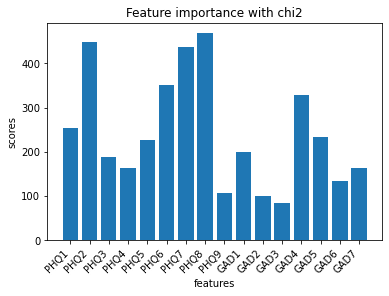

In [53]:
ax = plot_feature_importances(X_train,y_train, feature_names_in=rawdata.columns[:-1], score_func=chi2)
plt.show()

C:\Users\xps\AppData\Local\Temp/ipykernel_16676/3618988755.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with mutual_info_classif'}, xlabel='features', ylabel='scores'>

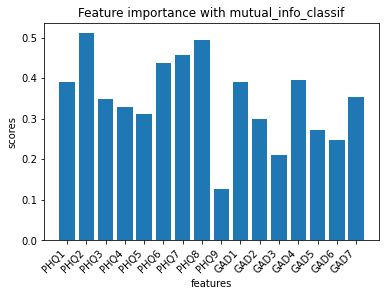

In [54]:
plot_feature_importances(X_train,y_train,feature_names_in=rawdata.columns[:-1], score_func=mutual_info_classif)

Feature selection experiments

In [55]:
models = [
    sklearn.svm.SVC(kernel='linear', random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE)
]
model_names = [
    'SVC',
    'Random Forest'
]
percentiles = [5, 10, 30, 50, 80, 100]

In [57]:
scores_chi2_all, features_chi2_all = eval_for_each_dataset(datasets=datasets,dataset_names=dataset_names, models=models,model_names=model_names, percentiles=percentiles)

In [58]:
scores_chi2_all

5         10        30        50        80   \
IADQ_df      SVC            0.811111  0.811111  0.811111  0.777778  0.833333   
             Random Forest  0.811111  0.811111  0.822222  0.811111  0.822222   
PHQ9_GAD7_df SVC            0.950893  0.982143  0.982143  0.991071  0.986607   
             Random Forest  0.950893  0.982143  0.982143  0.991071  0.982143   
PRMQ_df      SVC            0.829181   0.88968  0.875445  0.879004  0.875445   
             Random Forest  0.829181  0.886121  0.882562  0.907473  0.928826   
RAW_DDDT     SVC            0.690355  0.746193  0.746193  0.736041  0.741117   
             Random Forest  0.690355  0.730964  0.695431  0.690355  0.766497   

                                 100  
IADQ_df      SVC            0.833333  
             Random Forest  0.833333  
PHQ9_GAD7_df SVC            0.986607  
             Random Forest  0.986607  
PRMQ_df      SVC            0.900356  
             Random Forest  0.921708  
RAW_DDDT     SVC            0.751269  
             Random Forest  0.766497

In [62]:
scores_chi2_diff = scores_chi2_all.subtract(scores_chi2_all[100],axis='index')

In [63]:
scores_chi2_diff

5         10        30        50        80   \
IADQ_df      SVC           -0.022222 -0.022222 -0.022222 -0.055556       0.0   
             Random Forest -0.022222 -0.022222 -0.011111 -0.022222 -0.011111   
PHQ9_GAD7_df SVC           -0.035714 -0.004464 -0.004464  0.004464       0.0   
             Random Forest -0.035714 -0.004464 -0.004464  0.004464 -0.004464   
PRMQ_df      SVC           -0.071174 -0.010676 -0.024911 -0.021352 -0.024911   
             Random Forest -0.092527 -0.035587 -0.039146 -0.014235  0.007117   
RAW_DDDT     SVC           -0.060914 -0.005076 -0.005076 -0.015228 -0.010152   
             Random Forest -0.076142 -0.035533 -0.071066 -0.076142       0.0   

                            100  
IADQ_df      SVC            0.0  
             Random Forest  0.0  
PHQ9_GAD7_df SVC            0.0  
             Random Forest  0.0  
PRMQ_df      SVC            0.0  
             Random Forest  0.0  
RAW_DDDT     SVC            0.0  
             Random Forest  0.0

Lasso feature importance/selection

In [ ]:
scores_lasso, features_lasso = eval_for_each_dataset(datasets,dataset_names, models, model_names, percentiles,feature_select_func=loglasso_coefs)

In [ ]:
scores_lasso

5         10        30        50        80   \
IADQ_df      SVC            0.722222  0.722222  0.777778  0.822222  0.822222   
             Random Forest  0.722222  0.722222  0.822222  0.811111  0.788889   
PHQ9_GAD7_df SVC            0.950893  0.982143  0.982143  0.982143  0.982143   
             Random Forest  0.950893  0.982143  0.977679  0.982143  0.991071   
PRMQ_df      SVC            0.829181  0.857651   0.88968  0.900356  0.896797   
             Random Forest  0.829181  0.836299  0.882562  0.914591  0.921708   
RAW_DDDT     SVC            0.680203  0.720812  0.761421  0.741117  0.756345   
             Random Forest  0.680203  0.746193  0.730964  0.736041  0.766497   

                                 100  
IADQ_df      SVC            0.833333  
             Random Forest  0.833333  
PHQ9_GAD7_df SVC            0.986607  
             Random Forest  0.986607  
PRMQ_df      SVC            0.900356  
             Random Forest  0.921708  
RAW_DDDT     SVC            0.751269  
             Random Forest  0.766497

In [ ]:
data_exp = add_interactions(rawdata, col_names=['Pr1', 'Pr2', 'Pr3'])
data_exp = add_interactions(data_exp, col_names=['FA1', 'FA2', 'FA3'])
data_exp = add_interactions(data_exp, col_names=['FI1', 'FI2', 'FI3'])

X_exp = data_exp.drop([TARGET],axis=1)
y_exp = data_exp[TARGET]

KeyError: 'Pr1'

In [ ]:
X_exp_train, X_exp_tv, y_exp_train, y_exp_tv = train_test_split(X_exp, y_exp, test_size=TESTSIZE,random_state=RANDOM_STATE)

sc_exp = StandardScaler()
X_exp_train = sc_exp.fit_transform(X_exp_train)
X_exp_tv = sc_exp.transform(X_exp_tv)

X_exp_val, X_exp_test, y_exp_val, y_exp_test = train_test_split(X_exp_tv, y_tv, test_size=VALSIZE,random_state=RANDOM_STATE)

NameError: name 'y_tv' is not defined

In [ ]:
np.sum(y_exp_train == 1)/np.sum(y_exp_train==0)

0.9444444444444444

In [ ]:
# lasso logistic model with no interactions
loglasso = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=1000
).fit(X_train, y_train)

loglasso.score(X_val, y_val)

0.8208955223880597

In [ ]:
loglasso.coef_

array([[ 0.34551073, -0.7710643 , -0.32557168, -0.77609551, -0.70529487,
         0.14356044, -0.23835024,  0.01854565, -0.53042108]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'Pr3' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'FI3']


In [ ]:
# lasso logistic model with interactions
loglasso_exp = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=10000
).fit(X_exp_train, y_exp_train)

loglasso_exp.score(X_exp_val, y_exp_val)

0.8208955223880597

In [ ]:
loglasso_exp.coef_

array([[ 0.39602845, -0.1284921 ,  0.        , -1.00973356, -0.20137843,
         0.5125152 , -0.14046987,  0.45907492,  0.        ,  0.        ,
         0.4720242 , -0.5441529 , -0.77596032,  0.        ,  0.22291391,
        -0.89326129,  0.        ,  0.        , -0.02781083, -0.46856733,
        -0.43026883]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso_exp.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'Pr1.Pr2' 'Pr1.Pr3' 'Pr2.Pr3'
 'FA1.FA2' 'FA1.FA3' 'FI1.FI2' 'FI1.FI3' 'FI2.FI3']


In [ ]:
# ridge regression
logr = LogisticRegression(penalty='l2',random_state=RANDOM_STATE)
rfe = RFE(estimator=logr, n_features_to_select=5, step=1)
X_train_5 = rfe.fit_transform(X_train, y_train)

In [ ]:
X_val_5 = rfe.transform(X_val)
logr_5 = LogisticRegression(penalty='l2', random_state=RANDOM_STATE).fit(X_train_5, y_train)
logr_5.score(X_val_5, y_val)

0.8059701492537313

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
random_forest_params =  {
        'n_estimators': [1, 2, 5, 10],
        'max_depth': [1, 2, 3],
        'random_state': [RANDOM_STATE],
    }
model = RandomForestClassifier()
random_forest = GridSearchCV(model, random_forest_params)
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)

0.8208955223880597